In [9]:
import lstm

In [15]:
# get Microsoft's stock opening prices and create list of 15 day frames
times = lstm.get_time_series_daily("SPSC", filters=["1. open"], outputsize="full")
vectors = lstm.times_to_vectors(times)
frames = lstm.get_frames(vectors, seq_len=15) # each frame is 15+1 (trend length + prediction target) vectors

print(f"first frame: {frames[0]}")
print(f"second frame: {frames[1]}")

normalized_frames = lstm.normalize_frames(frames)

first frame: [['106.7800'], ['107.2700'], ['109.7800'], ['111.2300'], ['109.3900'], ['107.0300'], ['109.2500'], ['107.8700'], ['106.5200'], ['106.2800'], ['103.2900'], ['92.8600'], ['92.0000'], ['89.8900'], ['91.1000'], ['90.0700']]
second frame: [['107.2700'], ['109.7800'], ['111.2300'], ['109.3900'], ['107.0300'], ['109.2500'], ['107.8700'], ['106.5200'], ['106.2800'], ['103.2900'], ['92.8600'], ['92.0000'], ['89.8900'], ['91.1000'], ['90.0700'], ['89.8500']]


In [16]:
# seperate normalized frames into training and testing data
train, test = lstm.partition_data(normalized_frames, partition_coefficient=0.8)
# split training and testing data into sequences and their targets
x_train, y_train = lstm.seperate_xy(train)
x_test, y_test = lstm.seperate_xy(test)

print(f"training sequence 1: {x_train[0]}, target: {y_train[0]}")
print(f"testing sequence 1: {x_test[0]}, target: {y_test[0]}")

training sequence 1: [[0.0], [0.004588874321033831], [0.028095148904289102], [0.04167447087469567], [0.024442779546731686], [0.002341262408690703], [0.02313167259786475], [0.010207904101891874], [-0.0024349129050385], [-0.004682524817381517], [-0.032684023225323044], [-0.13036149091590188], [-0.1384154336017981], [-0.15817568833114815], [-0.14684397827308493]], target: [-0.1564899793968909]
testing sequence 1: [[0.0], [0.004166666666666652], [0.008928571428571397], [0.033333333333333215], [0.018452380952380887], [0.0625], [0.05476190476190457], [0.04166666666666652], [0.06071428571428572], [0.03392857142857153], [0.03392857142857153], [0.05297619047619051], [0.05654761904761907], [0.0886904761904761], [0.09761904761904772]], target: [0.07261904761904758]


In [17]:
# create LSTM model using the training data
model = lstm.setup_lstm_model(x_train, y_train)
print(model)

compilation time :  0.020442962646484375
Train on 1683 samples, validate on 89 samples
Epoch 1/1
1683/1683 [==============================] - 2s 1ms/step - loss: 0.0078 - val_loss: 0.0033


In [18]:
# predict results using the test data
predictions = lstm.predict_sequences_multiple(model, x_test)

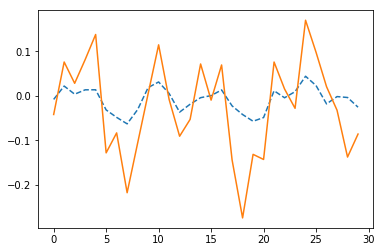

In [19]:
# plot the results of the last month
# (dashed line is prediction)
lstm.plot_results_multiple(predictions[-30:], y_test[-30:])